In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score


# Preprocessing
## Import data

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

In [4]:
data = pd.read_csv('data/cleaned_5272.csv', header=0)

In [5]:
# show all columns
data.columns

Index(['pl_name', 'hostname', 'sy_snum', 'sy_pnum', 'discoverymethod',
       'disc_year', 'pl_orbper', 'pl_orbeccen', 'pl_orbsmax', 'pl_rade',
       'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_insol', 'pl_eqt',
       'st_spectype', 'st_teff', 'st_rad', 'st_mass', 'st_met', 'st_metratio',
       'st_logg', 'sy_dist', 'planet_type'],
      dtype='object')

## Define features and target

In [6]:
# important variables
important_vars = ['pl_orbper', 'pl_orbeccen', 'pl_orbsmax', 'pl_rade', 'pl_bmasse']

# thrown variables
thrown_vars = ['pl_name', 'hostname', 'discoverymethod', 'disc_year', 'pl_bmassj', 'pl_radj', 'sy_dist']

# drop thrown variables
data.drop(thrown_vars, axis=1, inplace=True)

# define target variable
target = 'planet_type'

# split data into X and y according to target variable
X = data.drop(target, axis=1)
y = data[target]

## Encode categorical features

In [7]:
# encode categorical variables
spec_le = LabelEncoder()
met_le = LabelEncoder()
X['st_spectype'] = spec_le.fit_transform(X['st_spectype'])
X['st_metratio'] = met_le.fit_transform(X['st_metratio'])

## Split into train and test sets

In [8]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# find categorical variables
is_categorical = X.columns.isin(['st_spectype', 'st_metratio'])

# Random Forest
Random forest does not support missing values

# GradientBoost 
Gradient Boost does not support missing values

# HistGradientBoost 

In [20]:
# use grid search to find best parameters
from sklearn.model_selection import RandomizedSearchCV

# define parameters
param_grid = {'learning_rate': [0.02, 0.05, 0.1, 0.2], 'max_iter': [20, 50, 100, 200], 'max_depth': [2, 4, 8, 16], 'l2_regularization': [0.0, 0.1, 0.5, 1.0]}

# define model
model = HistGradientBoostingClassifier(random_state=42)

# define grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [21]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'l2_regularization': [0.0, 0.1, 0.5, 1.0],
                         'learning_rate': [0.02, 0.05, 0.1, 0.2],
                         'max_depth': [2, 4, 8, 16],
                         'max_iter': [20, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [22]:
grid_search.best_estimator_

HistGradientBoostingClassifier(l2_regularization=0.5, learning_rate=0.02,
                               max_depth=16, max_iter=200, random_state=42)

In [39]:
grid_search.best_params_

{'l2_regularization': 0.5,
 'learning_rate': 0.02,
 'max_depth': 16,
 'max_iter': 200}

In [23]:
grid_search.best_estimator_.score(X_test, y_test)

0.9725118483412323

In [37]:
mean_test_score = grid_search.cv_results_['mean_test_score'].reshape(4, 4, 4, 4)

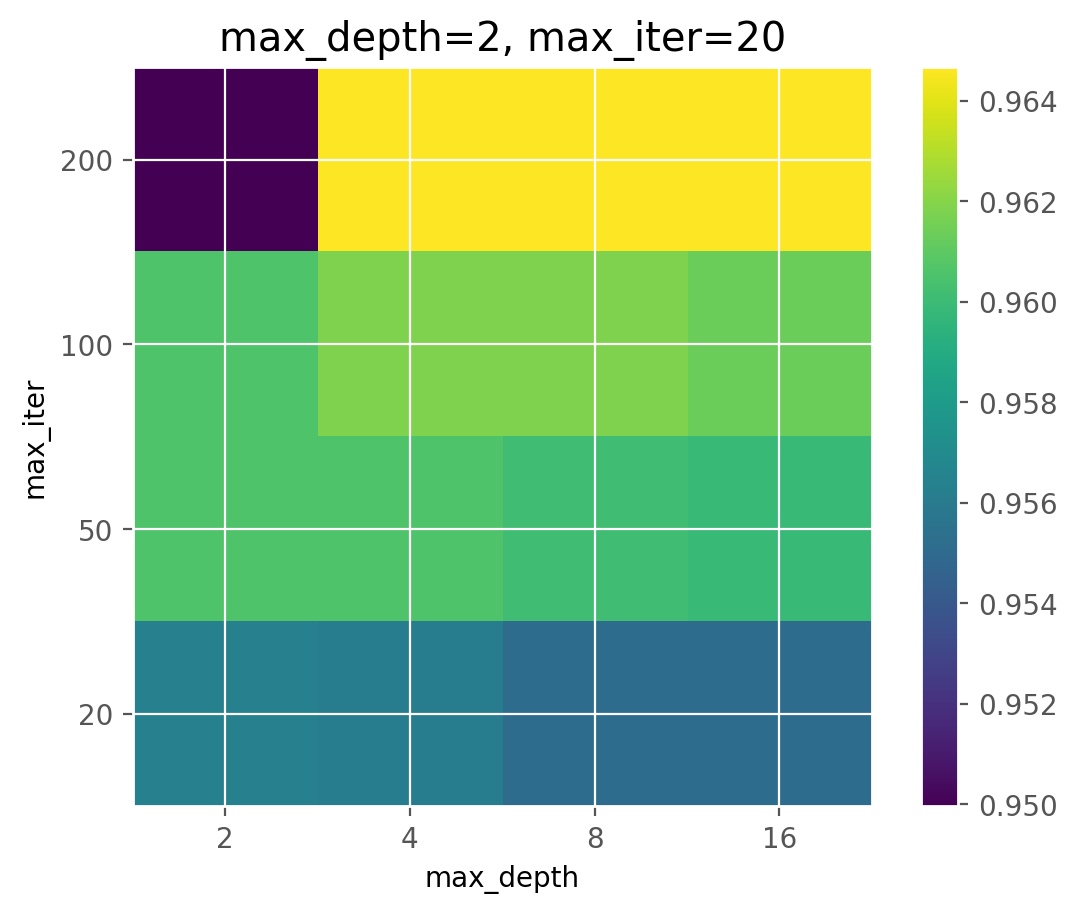

In [104]:
plt.imshow(mean_test_score[:, :, 0, 0].T, cmap='viridis', origin='lower')
plt.xticks(np.arange(4), param_grid['max_depth'])
plt.yticks(np.arange(4), param_grid['max_iter'])
plt.xlabel('max_depth')
plt.ylabel('max_iter')
plt.title('max_depth=2, max_iter=20')
plt.colorbar()
plt.show()

In [29]:
# plot mean test scores with respect to learning rate and max depth
grid_search.cv_results_['mean_test_score'].reshape(4, 4, 4, 4)[2, 0, 3, 3]

0.9708322792104479

In [118]:
# train accuracy
print('Accuracy on training set: {:.3f}'.format(gb.score(X_train, y_train)))

Accuracy on training set: 1.000


In [119]:
# compute test accuracy
y_pred = gb.predict(X_test)
accuracy_score(y_test, y_pred)

0.9715639810426541

In [120]:
gb.classes_

array(['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial',
       'Unknown'], dtype=object)

In [121]:
# confusion matrix
confusion_matrix(y_test, gb.predict(X_test))

array([[328,   2,   1,   0,   2],
       [  1, 338,   3,   0,   1],
       [  0,  15, 311,   0,   1],
       [  0,   1,   1,  48,   0],
       [  0,   2,   0,   0,   0]])

In [122]:
# classification report
print(classification_report(y_test, gb.predict(X_test)))

              precision    recall  f1-score   support

   Gas Giant       1.00      0.98      0.99       333
Neptune-like       0.94      0.99      0.96       343
 Super Earth       0.98      0.95      0.97       327
 Terrestrial       1.00      0.96      0.98        50
     Unknown       0.00      0.00      0.00         2

    accuracy                           0.97      1055
   macro avg       0.79      0.78      0.78      1055
weighted avg       0.97      0.97      0.97      1055



In [123]:
# apply roc score 
roc_auc_score(y_test, gb.predict_proba(X_test), multi_class='ovr')

0.9951327172545439

In [ ]:
# # use gradient boosting classifier
# gb = GradientBoostingClassifier(random_state=42)
# # set parameters to search over
# params = {'n_estimators': [100, 200, 300, 400, 500], 'learning_rate': [0.01, 0.1, 0.5, 1.0], 'max_depth': [1, 2, 3, 4, 5]}
# # use grid search to find best parameters
# grid = GridSearchCV(gb, params, cv=5, scoring='accuracy', n_jobs=-1)
# grid.fit(train.drop('planet_type', axis=1), train['planet_type'])

# XGBoost

In [125]:
# encode output variables
type_le = LabelEncoder()
y_train = type_le.fit_transform(y_train)
y_test = type_le.transform(y_test)

In [126]:
import xgboost as xgb

clf = xgb.XGBClassifier(eval_metric='mlogloss')
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

Text(0.5, 1.0, 'Feature Importance')

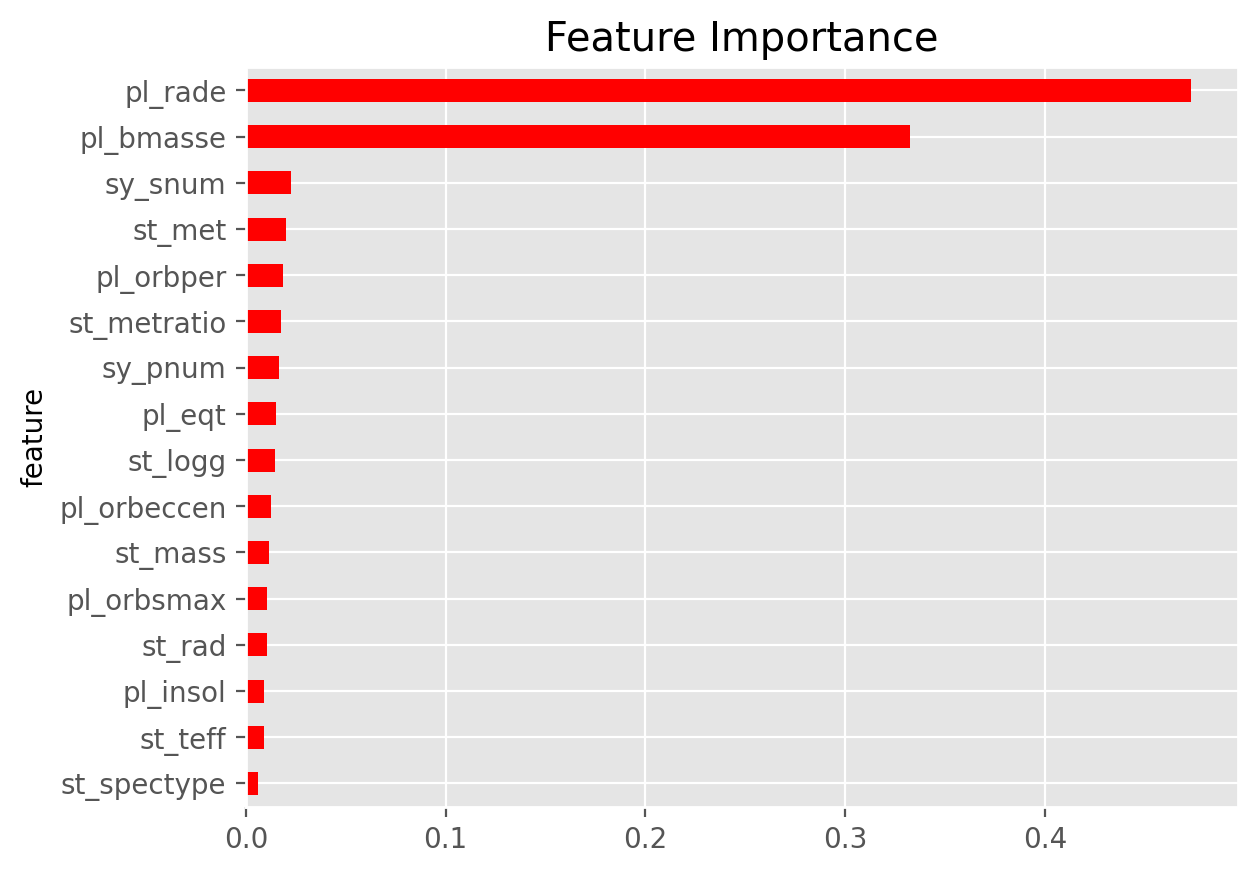

In [127]:
# create a dataframe 
feature_importance = pd.DataFrame({'feature': clf.feature_names_in_, 'importance': clf.feature_importances_})
# plot feature importance in hbar plots ranked by importance
feature_importance.sort_values(by='importance', ascending=True).plot(x='feature', y='importance', kind='barh', color='red', legend=False)
plt.title('Feature Importance')

In [131]:
# calculate accuracy
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.976303317535545

In [132]:
# confusion matrix
confusion_matrix(y_test, y_pred)

array([[330,   1,   1,   0,   1],
       [  0, 341,   2,   0,   0],
       [  0,  14, 311,   1,   1],
       [  0,   1,   1,  48,   0],
       [  0,   2,   0,   0,   0]])

# AdaBoost
AdaBoost does not support missing values